In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

## Testing FFT normalization

In [2]:
a = np.ones(2)
b = np.fft.rfft(a)
c = np.fft.irfft(b)
print a
print b
print c

[ 1.  1.]
[ 2.+0.j  0.+0.j]
[ 1.  1.]


## FFT summary
`rfft` (or `fft`) does this:
$$X_k=\sum_{n=0}^{N-1}x_ne^{-i2\pi k\frac{n}{N}}$$
`irfft` (or `ifft`) does this:
$$x_n=\frac{1}{N}\sum_{k=0}^{N-1}X_ke^{i2\pi k\frac{n}{N}}$$
We will denote the sums above without the prefactors by $DFT$ and $DFT^{-1}$ to be consistent with the *fftw3* package's notation. Then we have

`rfft` is $DFT$

`irfft` is $\frac{1}{N}DFT^{-1}$

## Discrete vs. continuous FFT
Continuous:
$$\tilde{f}(k)=\int\,dx\,f(x)e^{-ikx}$$
$$f(x)=\int\,\frac{dk}{2\pi}\tilde{f}(k)e^{ikx}$$

Let's assume we have a box of size $L$, discretized on $N$ points. The first integral above becomes:
$$\tilde{f}(k)=\frac{L}{N}\sum_{n=0}^{N-1}f(x_n)e^{-ikx_n}=\frac{L}{N}\sum_{n=0}^{N-1}f(x_n)e^{-ik\frac{L}{N}n}$$

Discretizing $k$ by:
$$k_j=\frac{2\pi}{L}j$$
we get:
$$\tilde{f}_j=\frac{L}{N}DFT(f_n)$$

Going back:
$$f_n=\frac{1}{L}DFT^{-1}(\tilde{f}_j)$$

## Power spectrum (linear)
Simple anzats:
$$P(k)=A\frac{k}{\left(1+(k/k_0)^2\right)^2}$$

We use this so that $P(k)\sim k$ for $k<k_0$ and $P(k)\sim k^{-3}$ for $k>k_0$.

The normalization $A$ will be determined from $\sigma_8$.

[]

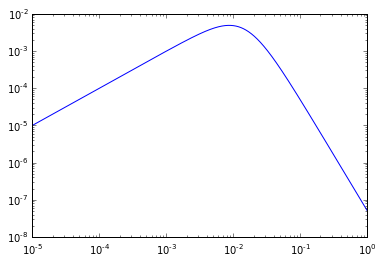

In [3]:
k_0 = 0.015
def p(k):
    return k / (1 + (k/k_0)**2)**2

k_array = np.arange(1e-5,1.0,1e-5)
p_array = p(k_array)
plt.plot(k_array, p_array)
plt.loglog()

40
3.53922469185e-05
28254.7757508


[]

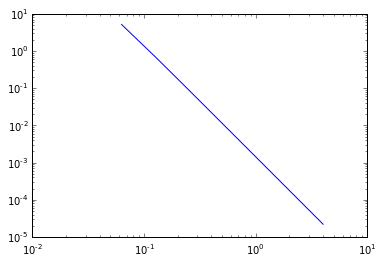

In [4]:
L = 100.
N = 128

def calculatePNorm(dist = 4.0, corr = 1.0):
    L1 = 100000.
    N1 = 1000000
    k_array1 = np.ones(N1 / 2 + 1)
    for i in np.arange(len(k_array1)):
        k_array1[i] = 2 * math.pi / L1 * i
    p_array1 = p(k_array1)
    s = np.fft.irfft(p_array1) / L1 * N1
    i = int(dist/L1*N1)
    print i
    print s[i]
    A = corr/s[i]
    print A
    return A

p_norm = calculatePNorm(4.0, 1.0)
k_array = np.ones(N / 2 + 1)
for i in np.arange(len(k_array)):
    k_array[i] = 2 * math.pi / L * i
p_array = p_norm * p(k_array)
plt.plot(k_array, p_array)
plt.loglog()

0.500422534763


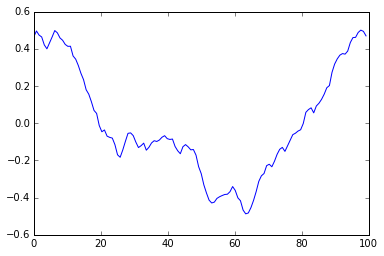

In [6]:
seed = 100
np.random.seed(seed)
r = np.random.randn(2 * (N/2+1))
r1 = r[0::2]
r2 = r[1::2]
delta_k_re = r1 * np.sqrt(L * p_array / 2)
delta_k_im = r2 * np.sqrt(L * p_array / 2)
#first and last elements must be real
delta_k_re[0] = r1[0] * np.sqrt(L * p_array[0])
delta_k_im[0] = 0
delta_k_re[-1] = r1[-1] * np.sqrt(L * p_array[-1])
delta_k_im[-1] = 0
delta_k = np.array(delta_k_re, dtype=complex)+np.complex(0,1)*delta_k_im
delta_x = np.fft.irfft(delta_k) / L * N
x_array = np.ones(N)
for i in xrange(N):
    x_array[i] = i * L / N
plt.plot(x_array, delta_x)
print delta_x.max()
np.savetxt('delta_x_python.txt', delta_x)

0.64941805995


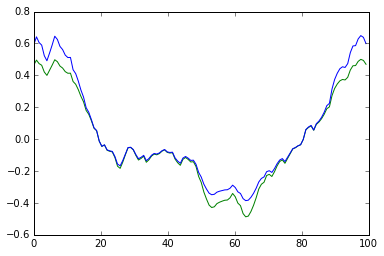

In [6]:
def deltaNonLin(delta):
    return np.exp(delta)-1

delta_nl = deltaNonLin(delta_x)
plt.plot(x_array, delta_x, 'g')
plt.plot(x_array, delta_nl, 'b')
print delta_nl.max()

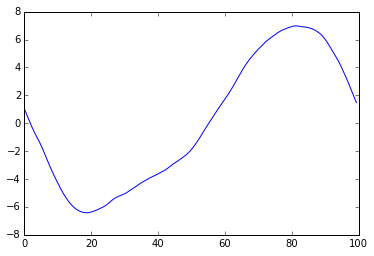

In [7]:
k_2_array = k_array * k_array
k_2_array[0] = 1.
def calculateV(d):
    d_k = np.fft.rfft(d) * L / N
    v_k = d_k * np.complex(0, 1) * k_array / k_2_array
    v_x = np.fft.irfft(v_k) * N / L
    return v_x

v = calculateV(delta_nl)
plt.plot(x_array, v)

In [8]:
timeit v1 = calculateV(delta_nl)

10000 loops, best of 3: 33.1 µs per loop


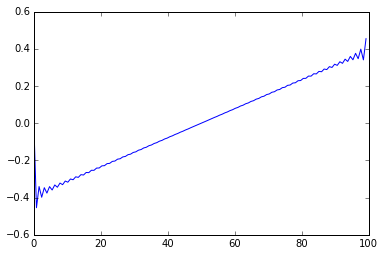

In [9]:
v_deriv_array_k = np.complex(0,1)*k_array / k_2_array
v_deriv_array = np.fft.irfft(v_deriv_array_k)

plt.plot(x_array, v_deriv_array)

In [10]:
def get_v_deriv(m, n, delta):
    if m > n:
        return v_deriv_array[m - n] * np.exp(delta[n])
    return -v_deriv_array[n - m] * np.exp(delta[n])

def test_v_derivs():
    epsilon = 0.001
    res = True
    for n in np.arange(N):
        delta_pert = delta_x.copy()
        delta_pert[n] += epsilon
        delta_nl_pert = deltaNonLin(delta_pert)
        v_pert = calculateV(delta_nl_pert)
        delta_v = v_pert - v
        numDeriv = delta_v / epsilon
        for m in np.arange(N):
            deriv = get_v_deriv(m, n, delta_x)
            if (numDeriv[m] == 0 and abs(deriv) > 1e-7) or (deriv == 0 and abs(numDeriv[m]) > 1e-7) or (numDeriv[m] != 0 and deriv != 0 and abs(deriv - numDeriv[m]) / numDeriv[m] > 1e-3):
                print 'problem: ' + str(m) + ' ' + str(n) + ' numerical derivative = ' + str(numDeriv[m]) + \
                ' actual derivative = ' + str(deriv)
                res = False
    return res
            
test_v_derivs()

True

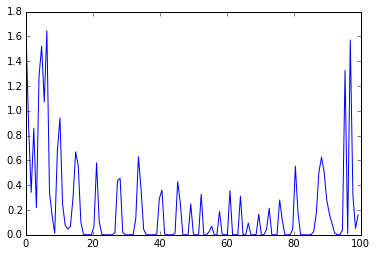

In [11]:
b = 0.1

def bringXToRange(x):
    if x < 0:
        y = -x
        n = math.ceil(y / L)
        x += n * L
        if x < 0:
            print "Bring X to range problem for x = " + str(x)
    n = int(math.floor(x / L))
    x -= n * L
    while x < 0:
        x += L
    while x >= L:
        x -= L
    return x

def calculateTauSlow(d_nl, v):
    rho = d_nl + 1
    tau = np.zeros(N)
    rsd_x_array = x_array + v
    for i in np.arange(N):
        rsd_x_array[i] = bringXToRange(rsd_x_array[i])
    #plt.plot(rsd_x_array, rho**2, '.')
    for i in np.arange(N):
        u = x_array[i]
        for j in np.arange(N):
            xv = rsd_x_array[j]
            d1 = u - xv
            d2 = d1 - L
            d3 = d1 + L
            tau[i] += rho[j]**2 * (np.exp(-d1**2 / b**2) + np.exp(-d2**2 / b**2) + np.exp(-d3**2 / b**2))
    tau *= L/N
    return tau

def bringIndexToRange(i):
    if i < 0:
        j = -i
        n = (j - 1) / N + 1
        i += n * N
        if i < 0:
            print 'bringIndexToRange problem for i = ' + str(i)
    return i % N

def calculateTau(d_nl, v):
    rho = d_nl + 1
    tau = np.zeros(N)
    rsd_x_array = x_array + v
    for j in np.arange(N):
        xv = rsd_x_array[j]
        x_1 = xv - 5 * b
        x_2 = xv + 5 * b
        i_1 = int(math.floor(x_1/L*N))-1
        i_2 = int(math.ceil(x_2/L*N))+1
        for i in np.arange(i_1, i_2 + 1):
            i_shifted = bringIndexToRange(i)
            u = i * L / N
            d = u - xv
            tau[i_shifted] += rho[j]**2 * np.exp(-d**2 / b**2)
    tau *= L/N
    return tau

def get_tau_deriv(m, n, delta, d_nl, v):
    u = x_array[m]
    rsd_x_array = x_array + v
    for i in np.arange(N):
        rsd_x_array[i] = bringXToRange(rsd_x_array[i])
    xv = rsd_x_array[n]
        
    d1 = u - xv
    d2 = d1 - L
    d3 = d1 + L
    rho = d_nl + 1
    res = 2 * rho[n] * np.exp(delta[n]) * (np.exp(-d1**2/b**2) + np.exp(-d2**2/b**2) + np.exp(-d3**2/b**2))
    
    for i in np.arange(N):
        xv = rsd_x_array[i]
        d1 = u - xv
        d2 = d1 - L
        d3 = d1 + L
        if abs(d1) > 5 * b and abs(d2) > 5 * b and abs(d3) > 5 * b:
            continue
        res += 2 * rho[i]**2 * (np.exp(-d1**2/b**2)*d1 + np.exp(-d2**2/b**2)*d2 + np.exp(-d3**2/b**2)*d3)/b**2 * get_v_deriv(i, n, delta)
    
    res *= L/N
    return res

def get_tau_derivs(delta, d_nl, v):
    rho = d_nl + 1
    res = np.zeros((N, N))
    rsd_x_array = x_array + v
    for n in np.arange(N):
        #first term
        xv = rsd_x_array[n]
        x_1 = xv - 5 * b
        x_2 = xv + 5 * b
        i_1 = int(math.floor(x_1/L*N))-1
        i_2 = int(math.ceil(x_2/L*N))+1
        for i in np.arange(i_1, i_2 + 1):
            i_shifted = bringIndexToRange(i)
            u = i * L / N
            d = u - xv
            res[i_shifted][n] += 2 * rho[n] * np.exp(delta[n]) * np.exp(-d**2/b**2)
    
        #second term
        for i in np.arange(N):
            xv = rsd_x_array[i]
            x_1 = xv - 5 * b
            x_2 = xv + 5 * b
            m_1 = int(math.floor(x_1/L*N))-1
            m_2 = int(math.ceil(x_2/L*N))+1
            for m in np.arange(m_1, m_2 + 1):
                m_shifted = bringIndexToRange(m)
                u = m * L / N
                d = u - xv
                res[m_shifted][n] += 2 * rho[i]**2 * np.exp(-d**2/b**2)*d/b**2 * get_v_deriv(i, n, delta)
    res *= L/N
    return res



tau = calculateTau(delta_nl, v)
plt.plot(x_array, tau)

In [12]:
timeit calculateTau(delta_nl, v)

100 loops, best of 3: 3.51 ms per loop


In [13]:
timeit calculateTauSlow(delta_nl, v)

10 loops, best of 3: 105 ms per loop


In [14]:
tau_test = calculateTauSlow(delta_nl, v)
tau_diff = np.abs((tau - tau_test) / tau_test)
print np.sum(tau_diff > 1e-10)

0


In [15]:
timeit get_tau_deriv(10, 10, delta_x, delta_nl, v)

1000 loops, best of 3: 335 µs per loop


In [16]:
timeit get_tau_derivs(delta_x, delta_nl, v)

1 loop, best of 3: 666 ms per loop


In [17]:
def test_tau_derivs():
    epsilon = 0.00001
    res = True
    tau_derivs = get_tau_derivs(delta_x, delta_nl, v)
    for n in np.arange(N):
        delta_pert = delta_x.copy()
        delta_pert[n] += epsilon
        delta_nl_pert = deltaNonLin(delta_pert)
        v_pert = calculateV(delta_nl_pert)
        tau_pert = calculateTau(delta_nl_pert, v_pert)
        delta_tau = tau_pert - tau
        numDeriv = delta_tau / epsilon
        for m in np.arange(N):
            #deriv = get_tau_deriv(m, n, delta_x, delta_nl, v)
            deriv = tau_derivs[m][n]
            if ((abs(numDeriv[m]) < 1e-7 and abs(deriv) > 1e-7) or (abs(deriv) < 1e-7 and abs(numDeriv[m]) > 1e-7) or (abs(numDeriv[m]) > 1e-7 and abs(deriv) > 1e-7 and abs(deriv - numDeriv[m]) / numDeriv[m] > 1e-1)):
                print 'problem: ' + str(m) + ' ' + str(n) + ' numerical derivative = ' + str(numDeriv[m]) + \
                ' actual derivative = ' + str(deriv) + ' tau = ' + str(tau[m])
                res = False
    return res
            
test_tau_derivs()

True

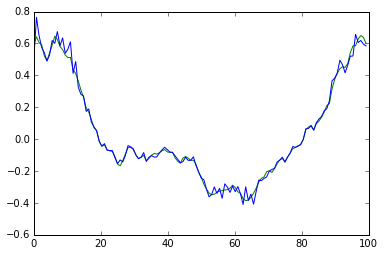

In [18]:
sigma_nl = np.abs(delta_nl) / 10
noiseSeed = seed + 100
np.random.seed(noiseSeed)
delta_nl_noisy = delta_nl + np.random.randn(N) * sigma_nl
plt.plot(x_array, delta_nl, 'g')
plt.plot(x_array, delta_nl_noisy, 'b')

In [19]:
def like_delta(x):
    my_delta_nl = deltaNonLin(x)
    diff = my_delta_nl - delta_nl_noisy
    return np.sum(diff**2/sigma_nl**2)

def like_delta_deriv(x):
    my_delta_nl = deltaNonLin(x)
    diff = my_delta_nl - delta_nl_noisy
    return 2 * diff * np.exp(x) / sigma_nl**2

def prior(x):
    my_delta_k = np.fft.rfft(x) * L / N
    res = 0
    #ignore the first element since the power spectrum there is 0
    #the last element is real
    for i in np.arange(1,N/2,1):
        res += abs(my_delta_k[i])**2 / (L * p_array[i])
    
    #multiply by two for conjugate k vals
    res *= 2
    res += abs(my_delta_k[-1])**2 / (L * p_array[i])
    return res

p_array_nonzero = p_array.copy()
p_array_nonzero[p_array_nonzero == 0.] = 1.

def prior_deriv(x):
    my_delta_k = np.fft.rfft(x) * L / N
    dp_ddelta_k = 2 * my_delta_k / (L * p_array_nonzero)
    dp_ddelta_x = np.fft.irfft(dp_ddelta_k) * L
    return dp_ddelta_x
    
def test_derivs():
    epsilon = 0.00001
    my_like = like_delta(delta_x)
    my_prior = prior(delta_x)
    my_like_deriv = like_delta_deriv(delta_x)
    my_prior_deriv = prior_deriv(delta_x)
    for i in np.arange(N):
        x = delta_x.copy()
        x[i] += epsilon
        new_like = like_delta(x)
        new_prior = prior(x)
        like_deriv = (new_like - my_like) / epsilon
        p_deriv = (new_prior - my_prior) / epsilon
        if abs((like_deriv - my_like_deriv[i]) / my_like_deriv[i]) > 1e-1:
            print 'Like deriv problem for ' + str(i) + ' expected ' + str(like_deriv) + ' got ' + str(my_like_deriv[i])
        if abs((p_deriv - my_prior_deriv[i]) / my_prior_deriv[i]) > 1e-1:
            print 'Prior deriv problem for ' + str(i) + ' expected ' + str(p_deriv) + ' got ' + str(my_prior_deriv[i])
            
test_derivs()

Prior deriv problem for 12 expected -13.2674342126 got -11.9808284333
Prior deriv problem for 17 expected -9.65467586695 got -11.1186541381
Prior deriv problem for 48 expected 6.70562116909 got 7.99222695955
Prior deriv problem for 72 expected 3.21713966116 got 4.50374544035
Like deriv problem for 103 expected 1593.43822501 got 1295.92056774
Prior deriv problem for 125 expected 2.09167294827 got 0.627694669819


In [20]:
prior(delta_x)

131.29138349624651

In [21]:
from scipy.optimize import fmin_l_bfgs_b

def f(x):
    return like_delta(x) + prior(x)

def f_deriv(x):
    return like_delta_deriv(x) + prior_deriv(x)

x0 = np.zeros(N)
x_min, f_min, d_min = fmin_l_bfgs_b(f, x0, fprime = f_deriv, maxfun = 10000000, maxiter = 10000000)

f_min = 125.10831376
n_iters = 477
funcalls = 569


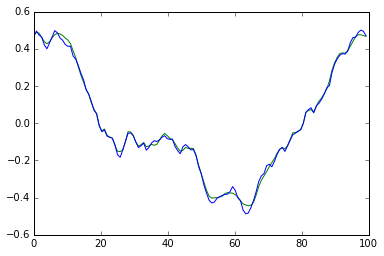

In [22]:
print "f_min = " + str(f_min)
print 'n_iters = ' + str(d_min['nit'])
print 'funcalls = ' + str(d_min['funcalls'])
plt.plot(x_array, x_min, 'g')
plt.plot(x_array, delta_x, 'b')

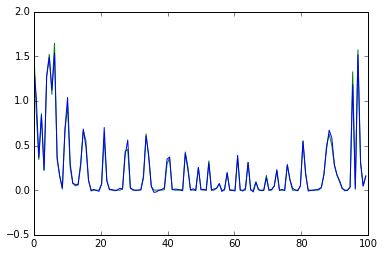

In [23]:
sigma_tau = tau / 10
sigma_tau[sigma_tau < 0.01] = 0.01
noiseSeed = seed + 100
np.random.seed(noiseSeed)
tau_noisy = tau + np.random.randn(N) * sigma_tau
plt.plot(x_array, tau, 'g')
plt.plot(x_array, tau_noisy, 'b')

In [24]:
def like_tau(x):
    my_delta_nl = deltaNonLin(x)
    my_v = calculateV(my_delta_nl)
    my_tau = calculateTau(my_delta_nl, my_v)
    diff = my_tau - tau_noisy
    return np.sum(diff**2/sigma_tau**2)

def like_tau_deriv(x):
    my_delta_nl = deltaNonLin(x)
    my_v = calculateV(my_delta_nl)
    my_tau = calculateTau(my_delta_nl, my_v)
    diff = my_tau - tau_noisy
    res = np.zeros(N)
    tau_derivs = get_tau_derivs(x, my_delta_nl, my_v)
    for i in np.arange(N):
        for j in np.arange(N):
            res[i] += 2 * diff[j] / sigma_tau[j]**2 * tau_derivs[j][i]
    
    return res

def test_like_tau_derivs():
    epsilon = 0.00001
    my_like = like_tau(delta_x)
    my_like_deriv = like_tau_deriv(delta_x)
    for i in np.arange(N):
        x = delta_x.copy()
        x[i] += epsilon
        new_like = like_tau(x)
        like_deriv = (new_like - my_like) / epsilon
        if (abs(my_like_deriv[i]) < 1e-7 and abs(like_deriv) > 1e-7) or (abs(like_deriv) < 1e-7 and abs(my_like_deriv[i]) > 1e-7) or (abs(like_deriv) > 1e-7 and abs(my_like_deriv[i]) > 1e-7 and abs((like_deriv - my_like_deriv[i]) / my_like_deriv[i]) > 1e-1):
            print 'Like deriv problem for ' + str(i) + ' expected ' + str(like_deriv) + ' got ' + str(my_like_deriv[i])

test_like_tau_derivs()

In [25]:
timeit like_tau_deriv(delta_x)

1 loop, best of 3: 682 ms per loop


In [36]:
def g(x):
    res = like_tau(x) + prior(x)
    print 'function evaluation: ' + str(res)
    return res

def g_deriv(x):
    return like_tau_deriv(x) + prior_deriv(x)

currentx = np.zeros(N)

def cb(x):
    #plt.plot(x_array, delta_x, 'b')
    #plt.plot(x_array, x, 'g')
    #plt.show()
    currentx = x

x0 = np.zeros(N)
x_min, g_min, d_min = fmin_l_bfgs_b(g, x0, fprime = g_deriv, maxfun = 10000000, maxiter = 10000000, callback = cb, m = 100)

function evaluation: 489295.922173
function evaluation: 31837.8127711
function evaluation: 65402.5598305
function evaluation: 13925.720756
function evaluation: 12410.2367298
function evaluation: 11329.4262867
function evaluation: 9409.89198442
function evaluation: 6997.37838706
function evaluation: 6785.12743492
function evaluation: 6275.69064474
function evaluation: 5851.43493149
function evaluation: 5967.78960855
function evaluation: 5716.1575913
function evaluation: 6472.80019467
function evaluation: 5663.76149402
function evaluation: 5586.28062816
function evaluation: 5445.90686062
function evaluation: 12361.991822
function evaluation: 5352.77718619
function evaluation: 5305.205981
function evaluation: 5269.68130311
function evaluation: 5208.81211915
function evaluation: 5145.27792653
function evaluation: 4913.45887203
function evaluation: 4753.28510774
function evaluation: 4597.5265395
function evaluation: 4515.74865035
function evaluation: 4426.42213986
function evaluation: 4306.

g_min = 465.26419715
n_iters = 335
funcalls = 385


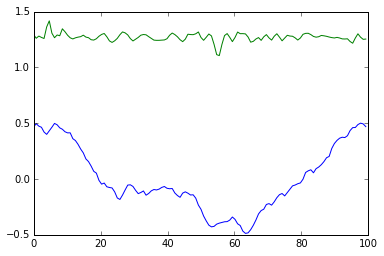

In [37]:
print "g_min = " + str(g_min)
print 'n_iters = ' + str(d_min['nit'])
print 'funcalls = ' + str(d_min['funcalls'])
plt.plot(x_array, x_min, 'g')
plt.plot(x_array, delta_x, 'b')

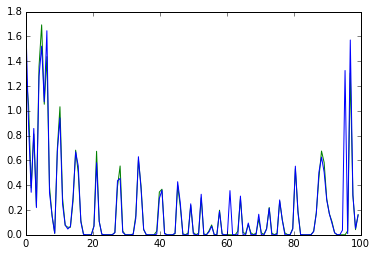

In [28]:
x_nl_min = deltaNonLin(x_min)
v_min = calculateV(x_nl_min)
tau_min = calculateTau(x_nl_min, v_min)
plt.plot(x_array, tau_min, 'g')
plt.plot(x_array, tau, 'b')

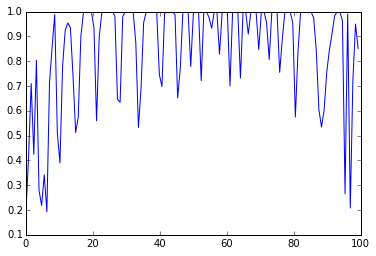

In [29]:
flux = np.exp(-tau)
plt.plot(x_array, flux)

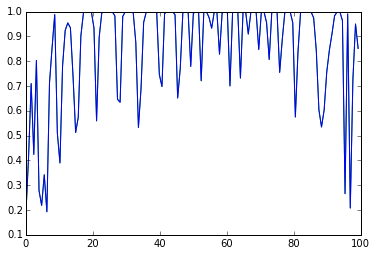

In [32]:
sigma_flux = flux * 0.01
noiseSeed = seed + 100
np.random.seed(noiseSeed)
flux_noisy = flux + 0 * np.random.randn(N) * sigma_flux
plt.plot(x_array, flux, 'g')
plt.plot(x_array, flux_noisy, 'b')

In [33]:
def like_flux(x):
    my_delta_nl = deltaNonLin(x)
    my_v = calculateV(my_delta_nl)
    my_tau = calculateTau(my_delta_nl, my_v)
    my_flux = np.exp(-my_tau)
    diff = my_flux - flux_noisy
    return np.sum(diff**2/sigma_flux**2)

def like_flux_deriv(x):
    my_delta_nl = deltaNonLin(x)
    my_v = calculateV(my_delta_nl)
    my_tau = calculateTau(my_delta_nl, my_v)
    my_flux = np.exp(-my_tau)
    diff = my_flux - flux_noisy
    res = np.zeros(N)
    tau_derivs = get_tau_derivs(x, my_delta_nl, my_v)
    for i in np.arange(N):
        for j in np.arange(N):
            res[i] += 2 * diff[j] / sigma_flux[j]**2 * (-my_flux[j]) * tau_derivs[j][i]
    
    return res

def test_like_flux_derivs():
    epsilon = 0.00001
    my_like = like_flux(delta_x)
    my_like_deriv = like_flux_deriv(delta_x)
    for i in np.arange(N):
        x = delta_x.copy()
        x[i] += epsilon
        new_like = like_flux(x)
        like_deriv = (new_like - my_like) / epsilon
        if (abs(my_like_deriv[i]) < 1e-7 and abs(like_deriv) > 1e-7) or (abs(like_deriv) < 1e-7 and abs(my_like_deriv[i]) > 1e-7) or (abs(like_deriv) > 1e-7 and abs(my_like_deriv[i]) > 1e-7 and abs((like_deriv - my_like_deriv[i]) / my_like_deriv[i]) > 1e-1):
            print 'Like deriv problem for ' + str(i) + ' expected ' + str(like_deriv) + ' got ' + str(my_like_deriv[i])

test_like_flux_derivs()

Like deriv problem for 0 expected 69.8484552201 got 0.0
Like deriv problem for 1 expected 74.1620766784 got 0.0
Like deriv problem for 2 expected 67.9289176277 got 0.0
Like deriv problem for 3 expected 73.4030946129 got 0.0
Like deriv problem for 4 expected 54.9187976525 got 0.0
Like deriv problem for 5 expected 66.8255437771 got 0.0
Like deriv problem for 6 expected 59.9479543316 got 0.0
Like deriv problem for 7 expected 78.6938545225 got 0.0
Like deriv problem for 8 expected 59.5086158034 got 0.0
Like deriv problem for 9 expected 84.1824249543 got 0.0
Like deriv problem for 10 expected 56.6714110672 got 0.0
Like deriv problem for 11 expected 75.8065255086 got 0.0
Like deriv problem for 12 expected 51.2640169878 got 0.0
Like deriv problem for 13 expected 67.2532263909 got 0.0
Like deriv problem for 14 expected 53.8135495688 got 0.0
Like deriv problem for 15 expected 56.3072286834 got 0.0
Like deriv problem for 16 expected 45.2752160019 got 0.0
Like deriv problem for 17 expected 46.973

In [35]:
def h(x):
    #print x
    res = like_flux(x) + prior(x)
    print 'function evaluation: ' + str(res)
    return res

def h_deriv(x):
    return like_flux_deriv(x) + prior_deriv(x)

currentx = np.zeros(N)

def cb(x):
    #plt.plot(x_array, delta_x, 'b')
    #plt.plot(x_array, x, 'g')
    #plt.show()
    currentx = x

x0 = np.zeros(N)
x_min, h_min, d_min = fmin_l_bfgs_b(h, x0, fprime = h_deriv, maxfun = 10000000, maxiter = 10000000, callback = cb, m = 100)

function evaluation: 356313.23028
function evaluation: 799136.038181
function evaluation: 418799.819392
function evaluation: 331269.591998
function evaluation: 321433.651989
function evaluation: 320531.923377
function evaluation: 419054.327517
function evaluation: 319733.598535
function evaluation: 298806.357716
function evaluation: 251565.112142
function evaluation: 183038.073441
function evaluation: 181216.92302
function evaluation: 160848.840503
function evaluation: 150953.383676
function evaluation: 147424.939054


KeyboardInterrupt: 

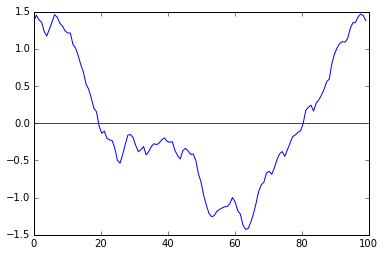

In [78]:
#print "h_min = " + str(h_min)
#print 'n_iters = ' + str(d_min['nit'])
#print 'funcalls = ' + str(d_min['funcalls'])
plt.plot(x_array, currentx, 'g')
plt.plot(x_array, delta_x, 'b')

In [76]:
h_deriv(x_min)

array([ -326.79395279,  -324.6231889 ,  -344.34652581,  -435.4925986 ,
        -552.33823402,  -611.68626111,  -759.83993562,  -722.87254067,
        -824.7931623 , -1079.36829991, -1345.49157553, -1271.75484839,
       -1265.29716784, -1061.89679364, -1008.87738674,  -946.82482896,
       -1102.79779135,  -723.82723182,  -204.40017349,  -211.18313044,
          34.28555118,    -7.54082457,    43.36653889,    27.75443394,
          70.73338401,    54.3744926 ,    71.03127088,    30.50893621,
         164.51676373,   162.69423491,   176.16934907,   140.19367663,
          56.10357499,   -39.2419523 ,    10.37925704,    -6.51134771,
        -280.28705838,  -562.89784435,  -219.43709521,  -429.87072892,
        -271.68459797,  -442.87618763,    96.88792082,   384.01469694,
         434.70503553,   428.97782084,   635.04844634,    68.74228515,
        -171.12592676,   -58.63814532,  -273.53380353,  -233.81935276,
        -203.46759113,  -271.6338961 ,  -143.20866387,  -141.95624825,
      